In [ ]:
! pip install scikit-mobility

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.7/167.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.14.0
    Uninstalling statsmodels-0.14.0:
      Successfully uninstalled statsmodels-0.14.0
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.13.2
    Uninstalling geopandas-0.13.2:
      Successfully uninstalled geopandas-0.13.2
  Attempting uninstall: folium
    Found existing installation: folium 0.14.0
    Uninstalling folium-0.14.0:
      Successfully uninstalled folium-0.14.0
ERROR: pip's dependency res

In [ ]:
# mount google drive to pull files in
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# imports
import pandas as pd
import skmob
from skmob.preprocessing import filtering, compression
from skmob.preprocessing import detection
from skmob.preprocessing import detection, clustering
import json
from datetime import datetime
from datetime import date
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 10)
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

### Import and Pre-process Data

In [ ]:
filename = "/content/drive/MyDrive/GOOGLoc/Records.json"
with open(filename) as json_file:
    data = json.load(json_file)
df = pd.DataFrame(data['locations'])
df.tail()

,latitudeE7,longitudeE7,accuracy,activity,source,deviceTag,deviceDesignation,timestamp,altitude,verticalAccuracy,...,serverTimestamp,deviceTimestamp,batteryCharging,formFactor,locationMetadata,inferredLocation,velocity,heading,placeId,activeWifiScan
1067408,378747488.0,-1.222587e+09,13.0,NaN,WIFI,-1792357495,NaN,2023-10-06T19:11:19.536Z,73.0,3.0,...,2023-10-06T20:01:38.468Z,2023-10-06T20:01:38.524Z,NaN,PHONE,NaN,NaN,NaN,NaN,NaN,"{'accessPoints': [{'mac': '335911376769', 'str..."
1067409,378747325.0,-1.222587e+09,13.0,NaN,WIFI,-1792357495,NaN,2023-10-06T19:12:22.876Z,73.0,2.0,...,2023-10-06T20:01:38.468Z,2023-10-06T20:01:38.524Z,NaN,PHONE,[{'wifiScan': {'accessPoints': [{'mac': '33591...,"[{'timestamp': '2023-10-06T19:12:22.875Z', 'la...",NaN,NaN,NaN,"{'accessPoints': [{'mac': '335911376769', 'str..."
1067410,378747555.0,-1.222587e+09,12.0,NaN,WIFI,-1792357495,NaN,2023-10-06T19:14:24.120Z,73.0,1.0,...,2023-10-06T20:01:38.468Z,2023-10-06T20:01:38.524Z,False,PHONE,[{'wifiScan': {'accessPoints': [{'mac': '33591...,"[{'timestamp': '2023-10-06T19:16:24.114Z', 'la...",NaN,NaN,NaN,"{'accessPoints': [{'mac': '335911376769', 'str..."
1067411,378747498.0,-1.222587e+09,13.0,NaN,WIFI,-1792357495,NaN,2023-10-06T19:24:24.211Z,73.0,1.0,...,2023-10-06T20:01:38.468Z,2023-10-06T20:01:38.524Z,False,PHONE,NaN,NaN,NaN,NaN,NaN,"{'accessPoints': [{'mac': '335911376769', 'str..."
1067412,378747487.0,-1.222587e+09,13.0,NaN,WIFI,-1792357495,NaN,2023-10-06T19:56:31.807Z,73.0,1.0,...,2023-10-06T20:01:38.468Z,2023-10-06T20:01:38.524Z,False,PHONE,[{'wifiScan': {'accessPoints': [{'mac': '33591...,"[{'timestamp': '2023-10-06T19:54:50.895Z', 'la...",NaN,NaN,NaN,"{'accessPoints': [{'mac': '335911376785', 'str..."


In [ ]:
# clean timestamps (thanks Alben! - these are a total pain to deal with)
df["timestamp"] = df['timestamp'].str.replace("T", " ")
df["timestamp"] = df['timestamp'].str.replace("Z", "")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Selecting desired dates - first week of october
rel = (df[(df['timestamp'] > '2023-10-01') & (df['timestamp'] < '2023-10-08')]).copy()
rel.reset_index(inplace=True)

# timestamp in seconds
rel['timeSec'] = rel['timestamp'].astype(np.int64)/10**9
# reset time such that first movement in parsed DataFrame occurs at time = 0s
rel['timeSec'] = rel['timeSec'] - min(rel['timeSec'])

# Convert lat & lon to actual values
rel['lat'] = rel['latitudeE7']/10000000
rel['lon'] = rel['longitudeE7']/10000000
rel['date'] = rel['timestamp']

# Cleaned df
clean = (rel[['lon', 'lat','date']]).copy()
clean.head()

,lon,lat,date
0,-122.382124,37.742895,2023-10-01 00:03:55.770
1,-122.382815,37.750289,2023-10-01 00:04:26.950
2,-122.382815,37.750289,2023-10-01 00:04:55.831
3,-122.388851,37.753047,2023-10-01 00:27:55.807
4,-122.385664,37.745682,2023-10-01 00:28:25.823


## Question 1 - How many points does the selected trajectory have?

In [ ]:
# Create a TrajDataFrame from a DataFrame
tdf = skmob.TrajDataFrame(clean,
                          latitude='lat',
                          datetime='date',
                          longitude='lon')
tdf['leaving_datetime'] = tdf.datetime #this field is added to add stops later
print(type(tdf))
tdf.head()

<class 'skmob.core.trajectorydataframe.TrajDataFrame'>


,lng,lat,datetime,leaving_datetime
0,-122.382124,37.742895,2023-10-01 00:03:55.770,2023-10-01 00:03:55.770
1,-122.382815,37.750289,2023-10-01 00:04:26.950,2023-10-01 00:04:26.950
2,-122.382815,37.750289,2023-10-01 00:04:55.831,2023-10-01 00:04:55.831
3,-122.388851,37.753047,2023-10-01 00:27:55.807,2023-10-01 00:27:55.807
4,-122.385664,37.745682,2023-10-01 00:28:25.823,2023-10-01 00:28:25.823


In [ ]:
# I didn't fly anywhere so I want to filter down to max speed in a car or BART train plus a buffer, which should help filter things down
ftdf = filtering.filter(tdf, max_speed_kmh=200.0, include_loops=True, ratio_max=1)
print(ftdf.parameters)
print('Points of the raw trajectory:\t\t%s'%len(tdf))
print('Points of the filtered trajectory:\t%s'%len(ftdf))
print('Filtered points:\t\t\t%s'%(len(tdf)-len(ftdf)))

{'filter': {'function': 'filter', 'max_speed_kmh': 200.0, 'include_loops': True, 'speed_kmh': 5.0, 'max_loop': 6, 'ratio_max': 1}}
Points of the raw trajectory:		2160
Points of the filtered trajectory:	2012
Filtered points:			148


## Question 2 - Is the recording of google locations continuous?

In [ ]:
# sort df
test_df = clean.copy()

test_df.sort_values(by='date', inplace=True)

# differences between consecutive timestamps
time_diffs = test_df['date'].diff()

# all deltas equal (continuous)?
continuous = time_diffs.equals(time_diffs.iloc[0])

if continuous:
    print("The time series has continuous timestamps.")
else:
    print("The time series has non-continuous timestamps.")

The time series has non-continuous timestamps.


Per the code above, the recording of locations is not conducted by Google on a continuous interval, as the timestamps given are not consecutive



## Question 3 - Detect and cluster the stops

### Stop Detection

In [ ]:
# First compress the dataset

# This code will collapse all datapoints within a 0.4km radius into a single
# point with the assumption that the granularity finer than .4km does not
# actually capture much meaning in terms of my location, but rather captures
# a lot of noise in how Google captures and stores my location
ctdf = compression.compress(ftdf, spatial_radius_km=.4)

# default stop radius factor
stdf_1 = detection.stay_locations(ctdf, stop_radius_factor=0.5, minutes_for_a_stop=15.0, spatial_radius_km=0.1, leaving_time=True)
print(stdf_1.parameters)
print('Points of the original trajectory:\t%s'%len(tdf))
print('Points of stops:\t\t\t%s\n'%len(stdf_1))

# 'zooming out' per se
stdf_2 = detection.stay_locations(ctdf, stop_radius_factor=1.0, minutes_for_a_stop=60.0, spatial_radius_km=1.5, leaving_time=True)
print(stdf_2.parameters)
print('Points of the original trajectory:\t%s'%len(tdf))
print('Points of stops:\t\t\t%s'%len(stdf_2))

{'filter': {'function': 'filter', 'max_speed_kmh': 200.0, 'include_loops': True, 'speed_kmh': 5.0, 'max_loop': 6, 'ratio_max': 1}, 'compress': {'function': 'compress', 'spatial_radius_km': 0.4}, 'detect': {'function': 'stay_locations', 'stop_radius_factor': 0.5, 'minutes_for_a_stop': 15.0, 'spatial_radius_km': 0.1, 'leaving_time': True, 'no_data_for_minutes': 1000000000000.0, 'min_speed_kmh': None}}
Points of the original trajectory:	2160
Points of stops:			35

{'filter': {'function': 'filter', 'max_speed_kmh': 200.0, 'include_loops': True, 'speed_kmh': 5.0, 'max_loop': 6, 'ratio_max': 1}, 'compress': {'function': 'compress', 'spatial_radius_km': 0.4}, 'detect': {'function': 'stay_locations', 'stop_radius_factor': 1.0, 'minutes_for_a_stop': 60.0, 'spatial_radius_km': 1.5, 'leaving_time': True, 'no_data_for_minutes': 1000000000000.0, 'min_speed_kmh': None}}
Points of the original trajectory:	2160
Points of stops:			12


#### Filter Set 1 Visualizations

In [ ]:
map_1 = stdf_1.plot_trajectory(max_points=1000, hex_color=-1, start_end_markers=False, zoom=15)
stdf_1.plot_stops(map_f=map_1, hex_color=-1)

#### Filter Set 2 Visualizations

In [ ]:
map_2 = stdf_2.plot_trajectory(max_points=1000, hex_color=-1, start_end_markers=False, zoom=15)
stdf_2.plot_stops(map_f=map_2, hex_color=-1)

### Clustering

In [ ]:
cl_stdf_1 = clustering.cluster(stdf_1,cluster_radius_km=0.5)
print(len(cl_stdf_1))

print(cl_stdf_1.parameters)
print('Points of the original trajectory:\t%s'%len(tdf))
print('Points of stops:\t\t\t%s'%len(stdf_1))
print('Points of clustered stops:\t\t\t%s'%len(cl_stdf_1))

35
{'filter': {'function': 'filter', 'max_speed_kmh': 200.0, 'include_loops': True, 'speed_kmh': 5.0, 'max_loop': 6, 'ratio_max': 1}, 'compress': {'function': 'compress', 'spatial_radius_km': 0.4}, 'detect': {'function': 'stay_locations', 'stop_radius_factor': 0.5, 'minutes_for_a_stop': 15.0, 'spatial_radius_km': 0.1, 'leaving_time': True, 'no_data_for_minutes': 1000000000000.0, 'min_speed_kmh': None}, 'cluster': {'function': 'cluster', 'cluster_radius_km': 0.5, 'min_samples': 1}}
Points of the original trajectory:	2160
Points of stops:			35
Points of clustered stops:			35


In [ ]:
cl_stdf_1.plot_stops(map_f=map_1)

In [ ]:
cl_stdf_2 = clustering.cluster(stdf_2,cluster_radius_km=2)
print(len(cl_stdf_2))

print(cl_stdf_2.parameters)
print('Points of the original trajectory:\t%s'%len(tdf))
print('Points of stops:\t\t\t%s'%len(stdf_2))
print('Points of clustered stops:\t\t\t%s'%len(cl_stdf_2))

12
{'filter': {'function': 'filter', 'max_speed_kmh': 200.0, 'include_loops': True, 'speed_kmh': 5.0, 'max_loop': 6, 'ratio_max': 1}, 'compress': {'function': 'compress', 'spatial_radius_km': 0.4}, 'detect': {'function': 'stay_locations', 'stop_radius_factor': 1.0, 'minutes_for_a_stop': 60.0, 'spatial_radius_km': 1.5, 'leaving_time': True, 'no_data_for_minutes': 1000000000000.0, 'min_speed_kmh': None}, 'cluster': {'function': 'cluster', 'cluster_radius_km': 2, 'min_samples': 1}}
Points of the original trajectory:	2160
Points of stops:			12
Points of clustered stops:			12


In [ ]:
cl_stdf_2.plot_stops(map_f=map_2)

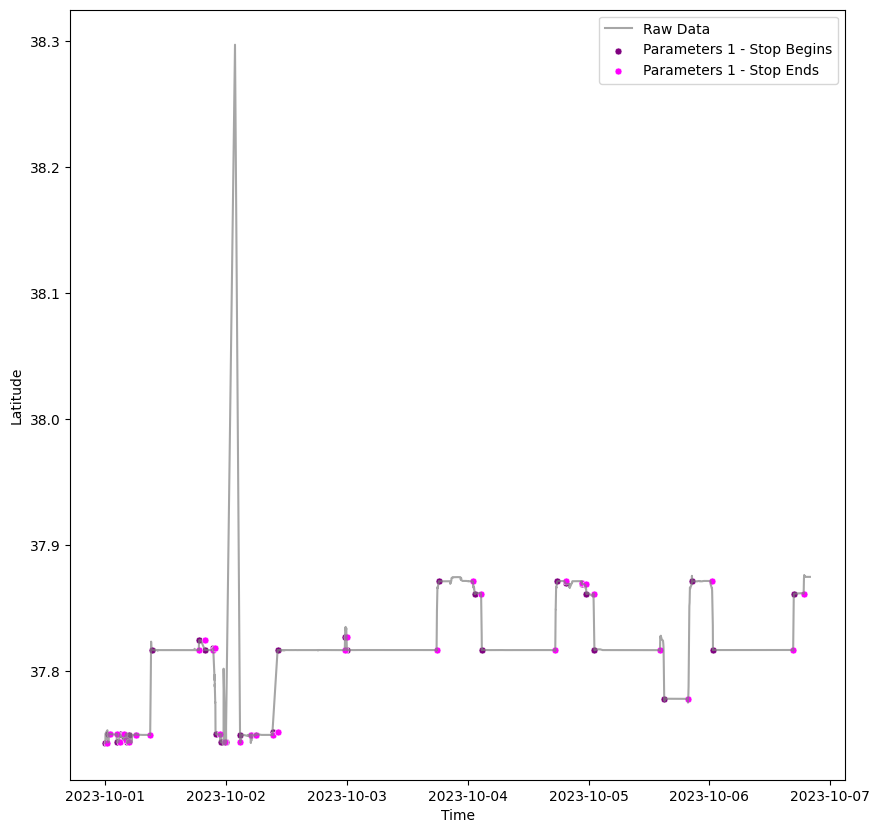

In [ ]:
# lineplot of raw data
sns.lineplot(x=tdf['datetime'], y=tdf['lat'], label='Raw Data', color='gray', alpha=0.7)

# scatter plot params 1
sns.scatterplot(x=stdf_1['datetime'], y=stdf_1['lat'], label='Parameters 1 - Stop Begins', color='purple', s=25)
sns.scatterplot(x=stdf_1['leaving_datetime'], y=stdf_1['lat'], label='Parameters 1 - Stop Ends', color='magenta', s=25)

plt.xlabel('Time')
plt.ylabel('Latitude')
plt.legend()
plt.show()

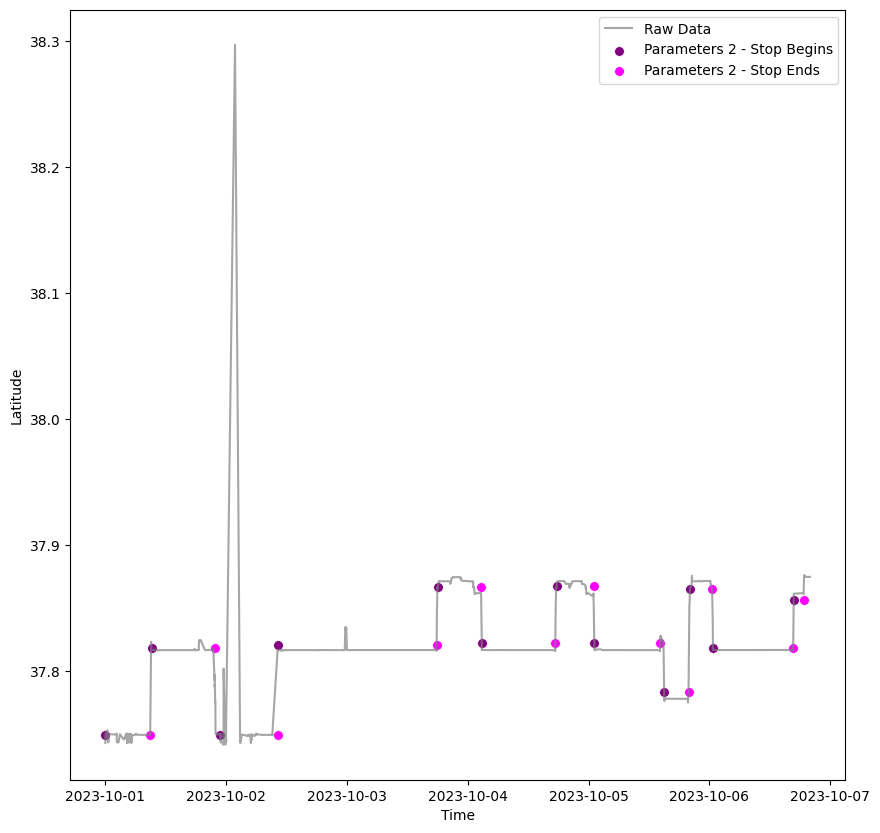

In [ ]:
# lineplot of raw data
sns.lineplot(x=tdf['datetime'], y=tdf['lat'], label='Raw Data', color='gray', alpha=0.7)

# scatter plot params 2
sns.scatterplot(x=stdf_2['datetime'], y=stdf_2['lat'], label='Parameters 2 - Stop Begins', color='purple', s=50)
sns.scatterplot(x=stdf_2['leaving_datetime'], y=stdf_2['lat'], label='Parameters 2 - Stop Ends', color='magenta', s=50)

plt.xlabel('Time')
plt.ylabel('Latitude')
plt.legend()
plt.show()

### Question 4 - Which set of parameters is better? Why?

I think that each set of parameters serves a different purpose -- in essence it depends on how granular we want the log of our movements to be. In the first set of parameters, I capture lots of details, like a stop in a specific class or, during this weekend I was at a music festival in the city and can even see stops at the different stages on the pier. This would be good for building a very specific diary of movement with the caveat that sometimes this type of location data is not great at pinpointing location to a tee, so there may be hiccups.

The second technique, I am making bigger holes in the net and only capturing larger fish, to use an allegory. I will only catch those stops where I am in a location for an extended period of time. This works well for brushing over some of the noise of say moving around within a festival or on campus. It seems to work when looking just at the stops detected.


Now - the parameters start to make a big difference when we begin to look at clustering. The first technique accurately separates activities like going to the gym (on south shattuck) from going to campus. The 'goodness' of this decision depends on what behavior we are trying to describe though. I often will go to the gym and to campus in one go, because it is most time efficient, but they really aren't the same thing and one can't consider 100% of my time as being spent doing school stuff. The second technique cleans out the noise and we end up with several sparsely populated clusters in the city. It does seem to erase a lot of my behavior, but it still captures a good high level overview of what was occuring that weekend.

### Question 5 - How many unique destinations were visited in the selected period?

In [ ]:
stdf_2['lat_lng'] = stdf_2['lat'].astype(str) + ", " + stdf_2['lng'].astype(str)
stdf_2['lat_lng'].value_counts()

37.74927535, -122.3824775           1
37.8181546, -122.26231089999999     1
37.7493235, -122.3824775            1
37.820738, -122.2607718             1
37.86654475, -122.25852545000001    1
37.8225345, -122.2670148            1
37.867471625, -122.25927025         1
37.821938450000005, -122.2683802    1
37.7833434, -122.3949012            1
37.8654609, -122.26462190000001     1
37.8184694, -122.2624707            1
37.8566199, -122.268229075          1
Name: lat_lng, dtype: int64

This method *technically* identifies 12 stops at 12 unique geographic coordinates. At the precision accuracy of 3 decimal places in a lat/long coordinate, the error is ~100m. At 4 decimal places, the error is ~10m (https://support.garmin.com/en-US/?faq=hRMBoCTy5a7HqVkxukhHd8). That said, I would argue that the first 2 should probably be considered a single location. Actually...there are probably quite a few on this list that should be considered single locations. The parameters themselves extract 12.

### Question 6 - Plot Cluster ID vs Time

In [ ]:
display(cl_stdf_1.head())
display(cl_stdf_2.head())

,lng,lat,datetime,leaving_datetime,cluster
0,-122.382124,37.742895,2023-10-01 00:03:55.770,2023-10-01 00:28:25.823,0
1,-122.382689,37.749981,2023-10-01 00:31:13.404,2023-10-01 00:57:51.279,0
2,-122.376988,37.749951,2023-10-01 00:57:51.279,2023-10-01 02:18:31.539,0
3,-122.382477,37.743383,2023-10-01 02:19:06.320,2023-10-01 02:57:09.274,0
4,-122.380351,37.749882,2023-10-01 02:57:09.274,2023-10-01 03:39:56.833,0


,lng,lat,datetime,leaving_datetime,cluster
0,-122.382477,37.749275,2023-10-01 00:03:55.770,2023-10-01 09:00:58.261,2
1,-122.262311,37.818155,2023-10-01 09:13:19.298,2023-10-01 21:45:39.271,0
2,-122.382477,37.749324,2023-10-01 22:45:18.457,2023-10-02 10:23:56.990,2
3,-122.260772,37.820738,2023-10-02 10:23:56.990,2023-10-03 17:51:08.471,0
4,-122.258525,37.866545,2023-10-03 18:08:45.636,2023-10-04 02:40:48.461,1


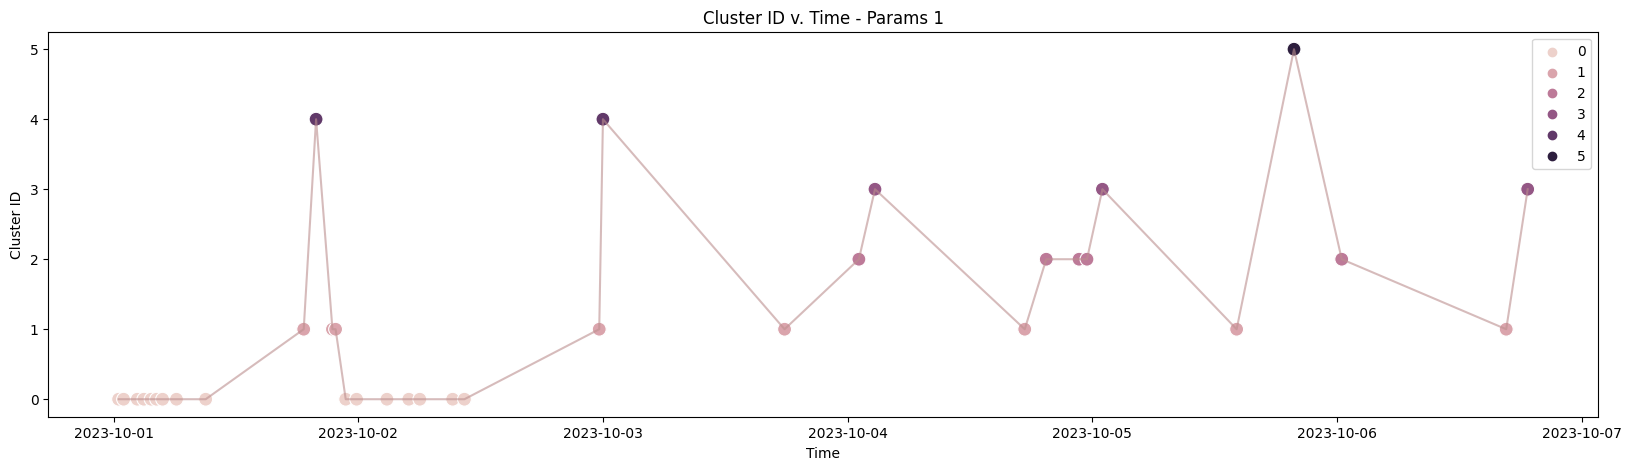

In [ ]:
plt.figure(figsize=(20,5))
sns.scatterplot(x=cl_stdf_1['leaving_datetime'], y=cl_stdf_1['cluster'], hue=cl_stdf_1['cluster'], s=100)
sns.lineplot(x=cl_stdf_1['leaving_datetime'], y=cl_stdf_1['cluster'], alpha=0.6, color = 'rosybrown')

plt.xlabel('Time')
plt.ylabel('Cluster ID')
plt.title('Cluster ID v. Time - Params 1')
plt.show()

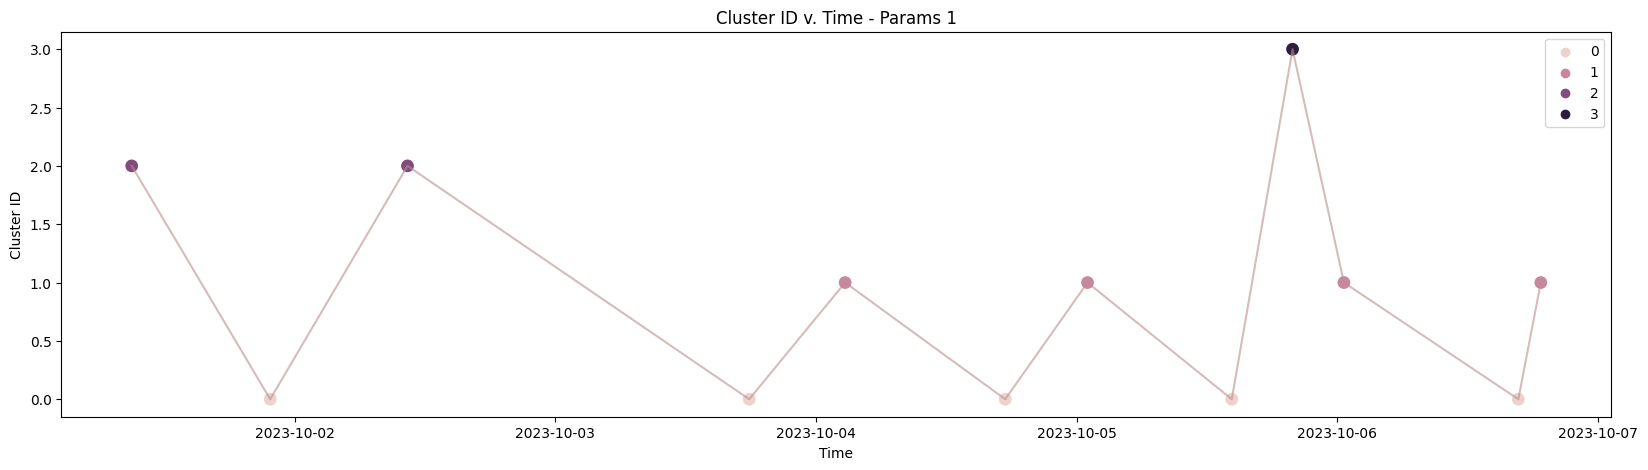

In [ ]:
plt.figure(figsize=(20,5))
sns.scatterplot(x=cl_stdf_2['leaving_datetime'], y=cl_stdf_2['cluster'], hue=cl_stdf_2['cluster'], s=100)
sns.lineplot(x=cl_stdf_2['leaving_datetime'], y=cl_stdf_2['cluster'], alpha=0.6, color='rosybrown')

plt.xlabel('Time')
plt.ylabel('Cluster ID')
plt.title('Cluster ID v. Time - Params 1')
plt.show()

### Question 7 - Report the Cluster ID of 'home' 'work' and 'other'

In [ ]:
cl_stdf_2.plot_stops(map_f=map_2)

In the 2nd set of parameters

*   <b>0</b> - Zero represents home. 37.816764, -122.263268 are the actual coordinates of my home and it lines up with those clustered in that region
*   <b>1</b> - Cluster 1 is school, but my stop at the gym on south shattuck is also lumped in there
*   <b>2</b> - Two is Portola festival at pier 80
*   <b>3</b> - Is my internship in SOMA

In [ ]:
cl_stdf_1.plot_stops(map_f=map_1)

In the 1st set of parameters

*   <b>0</b> - Zero is Portola Festival on Pier 80
*   <b>1</b> - One is home in this set
*   <b>2</b> - Parking garage and campus
*   <b>3</b> - Is the gym on south shattuck.
*   <b>4</b> - Is a meal I had in Piedmont and then a weird anomalous record maybe where I grabbed food? This makes me think that maybe the timestamps are off by a timezone and I need to convert them to pacific, because I wouldn't have gotten anything up Broadway after 11pm on a weeknight.
*   <b>5</b> - Is my internship in SOMA

Again...the 'best' set of parameters really depends on your goal. I think the second set does a better job summarizing into high level 'home' 'work' and 'other' broad band clusters. The first one, while it does highlight the activity at pier 80 a little too much, which is actually a one off event and not habitual, does separate out grabbing food or going to the gym, which better summarizes my behavior.